<h1><strong><u>Naive Bayes Test (A4)</u></strong><h1>

In [21]:
import matplotlib.pyplot as plt            
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, PrecisionRecallDisplay, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbLearn_Pipeline

<h2><u>Data Loading and Preprocessing</u></h2>

In [22]:
pd.read_csv("./SMSSpamCollection.txt", sep="\t", header=None).to_csv("sms_spam_collection.csv", index=False, header=["target", "message"])

In [23]:
data = pd.read_csv("sms_spam_collection.csv")
data

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [24]:
X = data['message']
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457,)

(1115,)

(4457,)

(1115,)

In [25]:
#Display message counts
hams = data[(data['target'] == 'ham')]
spams = data[(data['target'] == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))

Number of ham messages:  4825
Number of spam messages:  747
Fraction of spam messages: 13.41%


In [26]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

In [28]:
custom_f1_scorer_spam = make_scorer(f1_score, greater_is_better=True, pos_label='spam')
custom_f1_scorer_ham = make_scorer(f1_score, greater_is_better=True, pos_label='ham')

<h2><strong><u>Bayesian Model Selection</u></strong><h2>

<h3><strong><u>Validation Curve Tests</u></strong></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .....................................clf__alpha=0.1; total time=   1.0s
[CV] END ......................................clf__alpha=10; total time=   1.0s
[CV] END ...................................clf__alpha=0.001; total time=   1.1s
[CV] END ....................................clf__alpha=0.01; total time=   1.1s
[CV] END ..................................clf__alpha=0.0001; total time=   1.1s
[CV] END ...................................clf__alpha=0.001; total time=   1.0s
[CV] END .......................................clf__alpha=1; total time=   1.1s
[CV] END ..................................clf__alpha=0.0001; total time=   1.1s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    3.1s remaining:    3.1s


[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.5s
[CV] END ...................................clf__alpha=0.001; total time=   0.5s
[CV] END .......................................clf__alpha=1; total time=   0.5s
[CV] END .....................................clf__alpha=0.1; total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


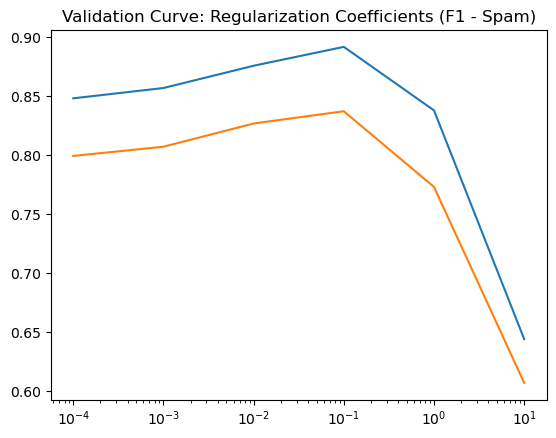

In [37]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", RandomUnderSampler(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring=custom_f1_scorer_spam,
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (F1 - Spam)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.5s remaining:    2.5s


[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.5s
[CV] END .......................................clf__alpha=1; total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


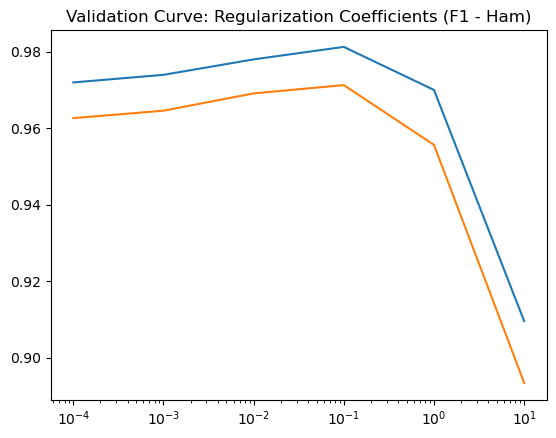

In [38]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", RandomUnderSampler(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring=custom_f1_scorer_ham,
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (F1 - Ham)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h3><strong><u>Cross-Validation Test</u></strong></h3>

In [36]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 
param_grid = {"clf__alpha": [0.1, 0.3, 0.5, 0.7, 0.9, 1]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=custom_f1_scorer_spam, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
nb_model = grid_search.best_estimator_
print(nb_model)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.8s
[CV] END .....................................clf__alpha=0.3; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END .....................................clf__alpha=0.3; total time=   0.8s
[CV] END .....................................clf__alpha=0.3; total time=   0.8s
[CV] END .....................................clf__alpha=0.3; total time=   0.7s
[CV] END .....................................clf__alpha=0.3; total time=   0.7s
[CV] END .....................................clf__alpha=0.5; total time=   0.7s
[CV] END .....................................clf

<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
The scoring metrics that I used for the Grid Search cross-validation test was the f1 score. F1 score is a good method to access the model's performance on the 'positive' class; spam in this instance; especially for imbalanced dataset or even datasets that have been synthetically balanced like this one. Switching between the RandomUnderSampler function and SMOTE while using a logarithmic range of regularization coefficients, I found that SMOTE performed better than the RandomUnderSampling function on all metrics excluding recall. The 'Recall' Validation Curve for both sampling functions yielded similar shapes except RandomUnderSampler had a better score of about 5%. For the regularization coefficient, the Validation Curve tests resulted in the best values being in the lowest range for the coefficient. On the other hand, recall in particular did not share that trend. The 'Recall' Validation Curve proceeded to improve as the regularization increased but trended downward after 1. Considering that, I believe the best regularization coefficient range that yields the best results across all metrics is 0.1-1. Also, decreasing the alpha value to a minimal value will most likely cause overfitting. Therefore, I used the range, 0.1-1, along with SMOTE in a pipeline for the Grid Search cross-validation test. After running the cross-validation test and the 'Model Evaluation' section for those five classifier metrics, I found that the best value for alpha was 0.1.

<h2><strong><u>Model Evaluation</u></strong></h2>

<h3><u>Learning Curve Tests</u></h3>

In [14]:
clf_metrics = {'precision': 'NPV', 'recall': 'Specificity'}

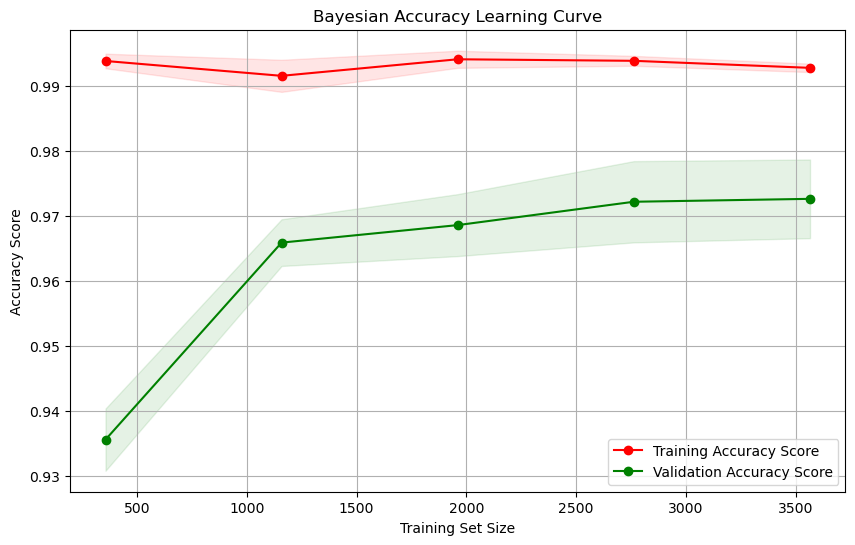

In [12]:
bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
    nb_model,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title(f"Bayesian Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel(f"Accuracy Score")
plt.grid()

plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                color="g")
plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
            label=f"Training Accuracy Score")
plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
            label=f"Validation Accuracy Score")

plt.legend(loc="best")
plt.show()

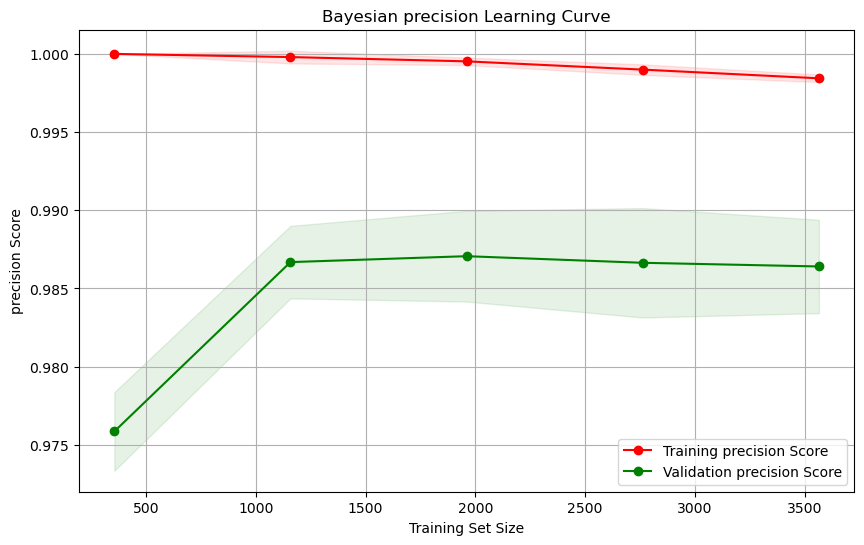

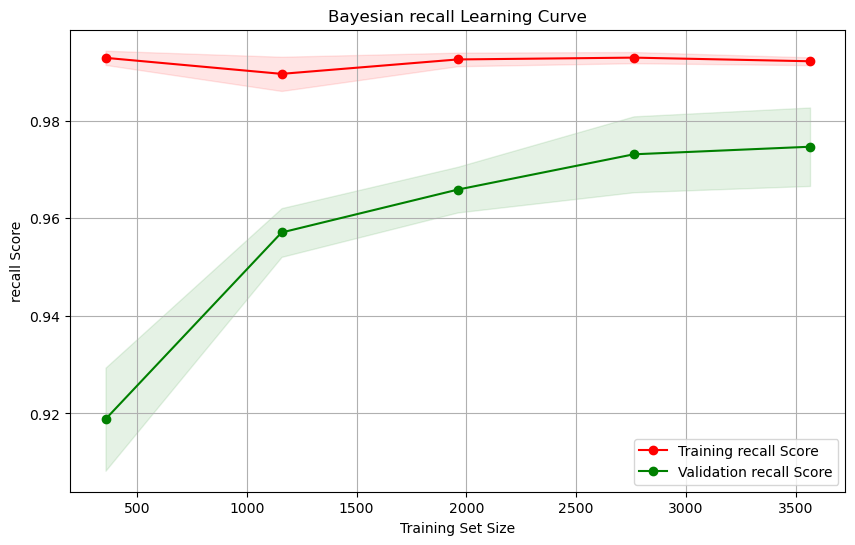

In [13]:
for key in clf_metrics:
    bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
        nb_model,
        X_train,
        y_train_transformed,
        cv=5,  # Number of folds for cross-validation
        scoring=key,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
    bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
    bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
    bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Bayesian {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                    bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                    bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                    color="g")
    plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
                label=f"Training {key} Score")
    plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
                label=f"Validation {key} Score")

    plt.legend(loc="best")
    plt.show()

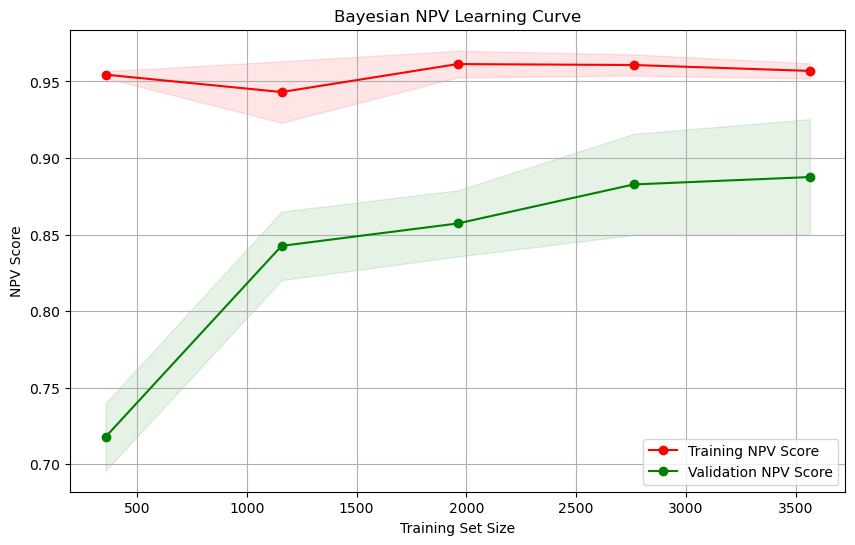

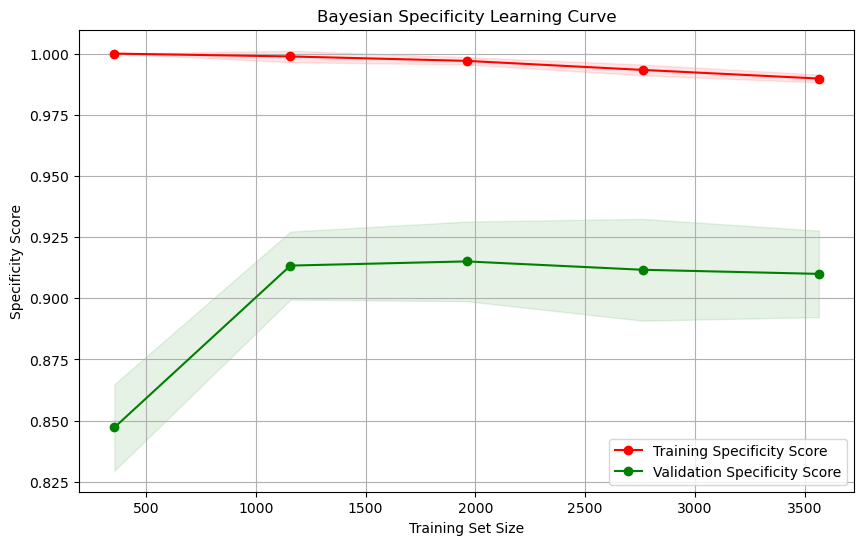

In [14]:
for key, value in clf_metrics.items():
    bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
        nb_model,
        X_train,
        y_train_transformed_rev,
        cv=5,  # Number of folds for cross-validation
        scoring=key,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
    bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
    bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
    bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Bayesian {value} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{value} Score")
    plt.grid()

    plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                    bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                    bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                    color="g")
    plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
                label=f"Training {value} Score")
    plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
                label=f"Validation {value} Score")

    plt.legend(loc="best")
    plt.show()

<h3><u>Evaluation Metrics</u></h3>

In [15]:
#Cross-Validation Loop
print("Accuracy")
nb_training_values = cross_val_score(nb_model, X_train, y_train, scoring='accuracy', cv=5)
print("CV Training Scores: ", nb_training_values)
np_nb_training_values = np.array(nb_training_values)
average = np.mean(np_nb_training_values)
stDev = np.std(np_nb_training_values)
print("Training Average and Standard Error: {:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV Training Scores:  [0.96636771 0.98318386 0.96969697 0.97418631 0.96857464]
Training Average and Standard Error: 0.97% ± 0.60% 



In [16]:
# precision and recall
for key in clf_metrics:
    print(f"{key}")
    nb_training_values = cross_val_score(nb_model, X_train, y=y_train_transformed, scoring=key, cv=5)
    print("CV Training Scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(f"Training Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

# NPV and Specificity
for key, value in clf_metrics.items():
    print(f"{value}")
    nb_training_values = cross_val_score(nb_model, X_train, y=y_train_transformed_rev, scoring=key, cv=5)
    print("CV Training Scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(f"Training Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

precision
CV Training Scores:  [0.98678996 0.99089727 0.98313878 0.98309493 0.98807947]
Training Average and Standard Error:  0.99% ± 0.30% 

recall
CV Training Scores:  [0.96511628 0.98449612 0.97932817 0.97800776 0.96507115]
Training Average and Standard Error:  0.97% ± 0.79% 

NPV
CV Training Scores:  [0.84375    0.94017094 0.88135593 0.91304348 0.8515625 ]
Training Average and Standard Error:  0.89% ± 3.65% 

Specificity
CV Training Scores:  [0.91525424 0.93220339 0.88888889 0.88983051 0.92372881]
Training Average and Standard Error:  0.91% ± 1.77% 



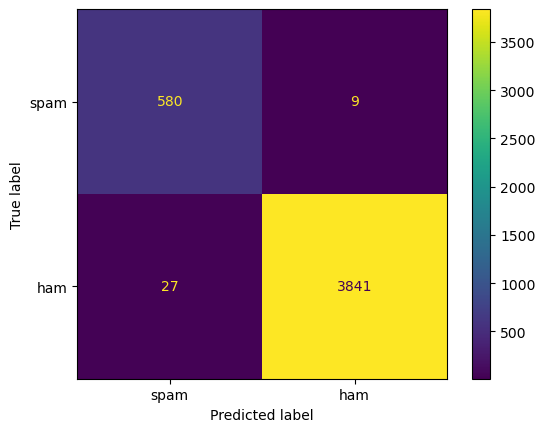

In [32]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(estimator=nb_model, X=X_train, y=y_train, labels=['spam', 'ham'])

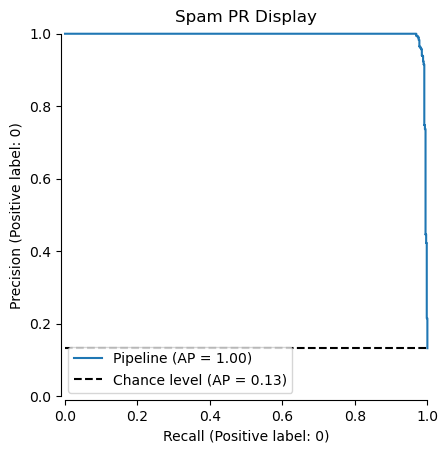

In [18]:
disp = PrecisionRecallDisplay.from_estimator(nb_model, X_train, y_train_transformed, pos_label=0, plot_chance_level=True, despine=True)
disp.ax_.set_title("Spam PR Display")
plt.show()

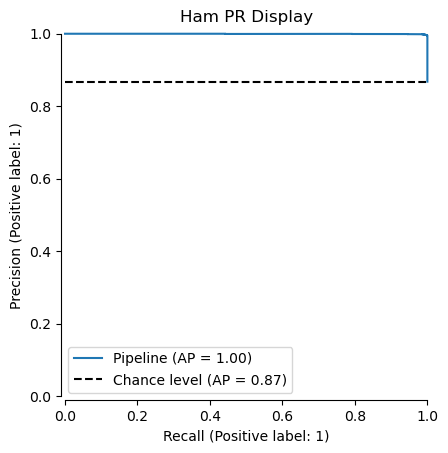

In [19]:
disp = PrecisionRecallDisplay.from_estimator(nb_model, X_train, y_train_transformed, pos_label=1, plot_chance_level=True, despine=True)
disp.ax_.set_title("Ham PR Display")
plt.show()

<h4><u>Findings From 'Model Evaluation' Phase</u></h4>
In my evaluation of the models that resulted from the cross-validation tests, the two alpha values that occurred were 0.9 and 0.1. The alpha value that had the better 'Model Evaluation' scores was 0.1. The learning curves yielded good results with validation scores trending upwards with increases in the training size. The precision learning curve and the specificity learning curve both have validation scores that plateau but still score highly. This is due to the model's peak performance being reached at that percentage for those metrics. The 'cross_val_score' function results were in keeping with the learning curve values which helps to solidify the model's evaluation results. The Confusion Matrix helps show that the model performed well on the training data with minimal False Negatives and False Positives compared to True Positive and True Negatives. The Precision-Recall plot displays a good curve that moves to the top-right corner of the plot indicating a good classifier model. Therefore, I will move forward to the 'Model Testing' section for this model.

<h2><strong><u>Model Testing</u></strong></h2>

<h3><u>Performance Metrics</u></h3>

In [10]:
test_predictions = nb_model.predict(X_test)

In [11]:
#Cross-Validation Loop
print("Accuracy")
nb_test_values = cross_val_score(nb_model, X_test, y_test, scoring='accuracy', cv=5)
print("CV test Scores: ", nb_test_values)
np_nb_test_values = np.array(nb_test_values)
average = np.mean(np_nb_test_values)
stDev = np.std(np_nb_test_values)
print("Test Average and Standard Error: {:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV test Scores:  [0.94170404 0.95067265 0.92376682 0.95964126 0.95067265]
Test Average and Standard Error: 0.95% ± 1.22% 



In [12]:
print(X_test.shape)
print(y_test_transformed.shape)

(1115,)
(1115,)


In [15]:
for key in clf_metrics:
    print(f"{key}")
    nb_test_values = cross_val_score(nb_model, X=X_test, y=y_test_transformed, scoring=key, cv=5)
    print("CV Test Scores: ", nb_test_values)
    np_nb_test_values = np.array(nb_test_values)
    average = np.mean(np_nb_test_values)
    stDev = np.std(np_nb_test_values)
    print(f"Test Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

for key, value in clf_metrics.items():
    print(f"{value}")
    nb_testing_values = cross_val_score(nb_model, X_test, y=y_test_transformed_rev, scoring=key, cv=5)
    print("CV Test Scores: ", nb_testing_values)
    np_nb_testing_values = np.array(nb_testing_values)
    average = np.mean(np_nb_testing_values)
    stDev = np.std(np_nb_testing_values)
    print(f"Test Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

precision
CV Test Scores:  [0.96335079 0.98387097 0.98870056 0.97395833 0.96825397]
Test Average and Standard Error:  0.98% ± 0.95% 

recall
CV Test Scores:  [0.95833333 0.953125   0.91623037 0.97905759 0.95811518]
Test Average and Standard Error:  0.95% ± 2.04% 

NPV
CV Test Scores:  [0.8        0.77777778 0.66666667 0.87096774 0.83870968]
Test Average and Standard Error:  0.79% ± 6.98% 

Specificity
CV Test Scores:  [0.77419355 0.90322581 0.9375     0.84375    0.8125    ]
Test Average and Standard Error:  0.85% ± 5.93% 



In [16]:
print(y_test.head())
print(y_test_transformed.head())
print(y_test_transformed_rev.head())

5086    ham
2120    ham
2318    ham
2917    ham
1352    ham
Name: target, dtype: object
0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64


In [ ]:
nb_test_accuracy = accuracy_score(y_test_transformed, test_predictions)
print("Naive Bayes Test Accuracy: {:.2f}%".format(nb_test_accuracy * 100))

nb_test_precision = precision_score(y_test_transformed, test_predictions, pos_label=1)
print("Naive Bayes Test Precision: {:.2f}%".format(nb_test_precision * 100))

nb_test_recall = recall_score(y_test_transformed, test_predictions, pos_label=1)
print("Naive Bayes Test Recall: {:.2f}%".format(nb_test_recall * 100))

nb_test_npv = precision_score(y_test_transformed_rev, test_predictions, pos_label=0)
print("Naive Bayes Negative Predictive Value Test Score: {:.2f}%".format(nb_test_npv * 100))

nb_test_specificity = recall_score(y_test_transformed, test_predictions, pos_label=0)
print("Naive Bayes Specificity Test Score: {:.2f}%".format(nb_test_specificity * 100))

Naive Bayes Test Accuracy: 96.05%
Naive Bayes Test Precision: 97.50%
Naive Bayes Test Recall: 97.91%
Naive Bayes Negative Predictive Value Test Score: 12.99%
Naive Bayes Specificity Test Score: 84.81%


Exception ignored in: <function ResourceTracker.__del__ at 0x106425bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103af9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106109bc0>
Traceback (most recent call last

*Note* I believe the classifier score functions are not working properly because the 'pos_label' argument seems to be backwards.

In [18]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)

ValueError: Mix of label input types (string and number)

In [ ]:
PrecisionRecallDisplay.from_estimator(nb_model, X_test, y_test, pos_label="spam", plot_chance_level=True, despine=True)

In [ ]:
PrecisionRecallDisplay.from_estimator(nb_model, X_test, y_test, pos_label="ham", plot_chance_level=True, despine=True)

Exception ignored in: <function ResourceTracker.__del__ at 0x106999bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1048d1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102729bc0>
Traceback (most recent call last